In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
from torchvision.transforms import Compose, ToTensor
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [4]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.training import EWC
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD

## Custom Libraries

In [7]:
import sys
sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.models.mlp_dropout import MLPDropout

# Dataset and definitions

## Preprocessing definitions

In [7]:
train_transform = Compose([
    ToTensor(),
])

test_transform = Compose([
    ToTensor(),
])

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [8]:
# mnist_train = MNIST(DATASETS_PATH, train=True, download=True, transform=train_transform)
# mnist_test = MNIST(DATASETS_PATH, train=False, download=True, transform=test_transform)

scenario = PermutedMNIST(10, seed=1234, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [9]:
# scenario = nc_benchmark(
#     mnist_train, mnist_test,
#     n_experiences=len(mnist_train.classes), shuffle=True, seed=1234, task_labels=False
# )

train_stream = scenario.train_stream
test_stream = scenario.test_stream

## Evaluation metrics definition

In [10]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()]
)

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [18]:
# model = MLP(n_classes=scenario.n_classes, n_channels=1, width=28, height=28)
model = MLPDropout(n_classes=scenario.n_classes, width=28, height=28, n_channels=1)
optimizer = SGD(model.parameters(), lr=1e-3)
criterion = CrossEntropyLoss()
strategy = EWC(
    model, optimizer, criterion, ewc_lambda=4.0, train_epochs=20, train_mb_size=256, evaluator=eval_plugin, mode="separate", eval_mb_size=128
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

In [19]:
results = list()

for experience in tqdm(train_stream):
    strategy.train(experience)
    metrics = strategy.eval(test_stream)
    results.append(metrics)

  0%|          | 0/10 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 235/235 [00:03<00:00, 59.61it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:03<00:00, 59.93it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:04<00:00, 58.28it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:03<00:00, 59.75it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:03<00:00, 59.89it/s]
Epoch 4 ended.
100%|██████████| 235/235 [00:03<00:00, 59.28it/s]
Epoch 5 ended.
100%|██████████| 235/235 [00:03<00:00, 59.79it/s]
Epoch 6 ended.
100%|██████████| 235/235 [00:04<00:00, 57.31it/s]
Epoch 7 ended.
100%|██████████| 235/235 [00:04<00:00, 55.88it/s]
Epoch 8 ended.
100%|██████████| 235/235 [00:04<00:00, 49.48it/s]
Epoch 9 ended.
100%|██████████| 235/235 [00:04<00:00, 54.27it/s]
Epoch 10 ended.
100%|██████████| 235/235 [00:04<00:00, 55.28it/s]
Epoch 11 ended.
100%|██████████| 235/235 [00:04<00:00, 56.39it/s]
Epoch 12 ended.
100%|██████████| 235/235 [00:04<00:00, 57.14it/s]
Epoch 13 ended.
100%|██████████| 235/235 [00:04<00:00, 56.94it/s]


 10%|█         | 1/10 [01:31<13:43, 91.54s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1370
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.2107
-- >> Start of training phase << --
100%|██████████| 235/235 [00:04<00:00, 50.98it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:04<00:00, 51.81it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:04<00:00, 50.61it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:04<00:00, 51.54it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:04<00:00, 52.04it/s]
Epoch 4 ended.
100%|██████████| 235/235 [00:04<00:00, 52.16it/s]
Epoch 5 ended.
100%|██████████| 235/235 [00:04<00:00, 52.14it/s]
Epoch 6 ended.
100%|██████████| 235/235 [00:04<00:00, 52.05it/s]
Epoch 7 ended.
100%|██████████| 235/235 [00:04<00:00, 52.14it/s]
Epoch 8 ended.
100%|██████████| 235/235 [00:04<00:00, 50.91it/s]
Epoch 9 ended.
100%|██████████| 235/235 [00:04<00:00, 52.07it/s]
Epoch 10 ended.
100%|██████████| 235/235 [00:04<00:00, 51.7

 20%|██        | 2/10 [03:11<12:52, 96.54s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1787
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.2860
-- >> Start of training phase << --
100%|██████████| 235/235 [00:04<00:00, 47.73it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:04<00:00, 47.28it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:05<00:00, 46.55it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:04<00:00, 47.56it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:04<00:00, 47.28it/s]
Epoch 4 ended.
100%|██████████| 235/235 [00:04<00:00, 47.57it/s]
Epoch 5 ended.
100%|██████████| 235/235 [00:04<00:00, 47.24it/s]
Epoch 6 ended.
100%|██████████| 235/235 [00:04<00:00, 47.26it/s]
Epoch 7 ended.
100%|██████████| 235/235 [00:05<00:00, 46.38it/s]
Epoch 8 ended.
100%|██████████| 235/235 [00:05<00:00, 46.23it/s]
Epoch 9 ended.
100%|██████████| 235/235 [00:04<00:00, 47.26it/s]
Epoch 10 ended.
100%|██████████| 235/235 [00:04<00:00, 47.1

 30%|███       | 3/10 [05:00<11:55, 102.16s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1567
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.3482
-- >> Start of training phase << --
100%|██████████| 235/235 [00:05<00:00, 43.95it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:05<00:00, 43.58it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:05<00:00, 43.13it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:05<00:00, 43.92it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:05<00:00, 43.72it/s]
Epoch 4 ended.
100%|██████████| 235/235 [00:05<00:00, 43.93it/s]
Epoch 5 ended.
100%|██████████| 235/235 [00:05<00:00, 43.69it/s]
Epoch 6 ended.
100%|██████████| 235/235 [00:05<00:00, 43.80it/s]
Epoch 7 ended.
100%|██████████| 235/235 [00:05<00:00, 43.64it/s]
Epoch 8 ended.
100%|██████████| 235/235 [00:05<00:00, 42.99it/s]
Epoch 9 ended.
100%|██████████| 235/235 [00:05<00:00, 43.45it/s]
Epoch 10 ended.
100%|██████████| 235/235 [00:05<00:00, 43.7

 40%|████      | 4/10 [06:57<10:48, 108.02s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1414
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4114
-- >> Start of training phase << --
100%|██████████| 235/235 [00:05<00:00, 41.12it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:05<00:00, 40.78it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:05<00:00, 40.26it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:05<00:00, 40.73it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:05<00:00, 40.76it/s]
Epoch 4 ended.
100%|██████████| 235/235 [00:05<00:00, 40.65it/s]
Epoch 5 ended.
100%|██████████| 235/235 [00:05<00:00, 40.73it/s]
Epoch 6 ended.
100%|██████████| 235/235 [00:05<00:00, 40.73it/s]
Epoch 7 ended.
100%|██████████| 235/235 [00:05<00:00, 40.74it/s]
Epoch 8 ended.
100%|██████████| 235/235 [00:05<00:00, 40.00it/s]
Epoch 9 ended.
100%|██████████| 235/235 [00:05<00:00, 40.63it/s]
Epoch 10 ended.
100%|██████████| 235/235 [00:05<00:00, 40.3

 50%|█████     | 5/10 [09:02<09:30, 114.20s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1503
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4841
-- >> Start of training phase << --
100%|██████████| 235/235 [00:06<00:00, 37.83it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:06<00:00, 37.93it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:06<00:00, 36.25it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:16<00:00, 14.32it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:06<00:00, 37.50it/s]
Epoch 4 ended.
100%|██████████| 235/235 [00:06<00:00, 37.51it/s]
Epoch 5 ended.
100%|██████████| 235/235 [00:06<00:00, 37.43it/s]
Epoch 6 ended.
100%|██████████| 235/235 [00:06<00:00, 37.53it/s]
Epoch 7 ended.
100%|██████████| 235/235 [00:06<00:00, 37.26it/s]
Epoch 8 ended.
100%|██████████| 235/235 [00:06<00:00, 36.60it/s]
Epoch 9 ended.
100%|██████████| 235/235 [00:06<00:00, 37.26it/s]
Epoch 10 ended.
100%|██████████| 235/235 [00:06<00:00, 37.3

 60%|██████    | 6/10 [11:27<08:19, 124.77s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1218
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5570
-- >> Start of training phase << --
100%|██████████| 235/235 [00:06<00:00, 35.48it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:06<00:00, 36.18it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:06<00:00, 35.56it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:06<00:00, 35.07it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:06<00:00, 35.33it/s]
Epoch 4 ended.
100%|██████████| 235/235 [00:06<00:00, 35.42it/s]
Epoch 5 ended.
100%|██████████| 235/235 [00:06<00:00, 35.21it/s]
Epoch 6 ended.
100%|██████████| 235/235 [00:06<00:00, 35.10it/s]
Epoch 7 ended.
100%|██████████| 235/235 [00:06<00:00, 35.15it/s]
Epoch 8 ended.
100%|██████████| 235/235 [00:06<00:00, 35.46it/s]
Epoch 9 ended.
100%|██████████| 235/235 [00:06<00:00, 34.61it/s]
Epoch 10 ended.
100%|██████████| 235/235 [00:06<00:00, 35.5

 70%|███████   | 7/10 [13:49<06:30, 130.14s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1053
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.6182
-- >> Start of training phase << --
100%|██████████| 235/235 [00:06<00:00, 33.67it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:06<00:00, 33.77it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:06<00:00, 34.17it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:07<00:00, 33.42it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:06<00:00, 33.98it/s]
Epoch 4 ended.
100%|██████████| 235/235 [00:07<00:00, 31.78it/s]
Epoch 5 ended.
100%|██████████| 235/235 [00:07<00:00, 33.05it/s]
Epoch 6 ended.
100%|██████████| 235/235 [00:07<00:00, 33.12it/s]
Epoch 7 ended.
100%|██████████| 235/235 [00:07<00:00, 32.91it/s]
Epoch 8 ended.
100%|██████████| 235/235 [00:07<00:00, 33.08it/s]
Epoch 9 ended.
100%|██████████| 235/235 [00:07<00:00, 32.35it/s]
Epoch 10 ended.
100%|██████████| 235/235 [00:07<00:00, 32.9

 80%|████████  | 8/10 [16:21<04:34, 137.24s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1221
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.6800
-- >> Start of training phase << --
100%|██████████| 235/235 [00:07<00:00, 30.59it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:07<00:00, 30.81it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:07<00:00, 30.03it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:07<00:00, 30.54it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:07<00:00, 30.23it/s]
Epoch 4 ended.
100%|██████████| 235/235 [00:07<00:00, 30.53it/s]
Epoch 5 ended.
100%|██████████| 235/235 [00:07<00:00, 30.49it/s]
Epoch 6 ended.
100%|██████████| 235/235 [00:07<00:00, 30.42it/s]
Epoch 7 ended.
100%|██████████| 235/235 [00:07<00:00, 30.47it/s]
Epoch 8 ended.
100%|██████████| 235/235 [00:07<00:00, 30.21it/s]
Epoch 9 ended.
100%|██████████| 235/235 [00:07<00:00, 30.49it/s]
Epoch 10 ended.
100%|██████████| 235/235 [00:07<00:00, 29.6

 90%|█████████ | 9/10 [19:06<02:25, 145.89s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1439
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.7482
-- >> Start of training phase << --
100%|██████████| 235/235 [00:08<00:00, 28.91it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:08<00:00, 28.69it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:08<00:00, 28.62it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:08<00:00, 28.66it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:08<00:00, 27.97it/s]
Epoch 4 ended.
100%|██████████| 235/235 [00:08<00:00, 28.21it/s]
Epoch 5 ended.
100%|██████████| 235/235 [00:08<00:00, 28.24it/s]
Epoch 6 ended.
100%|██████████| 235/235 [00:08<00:00, 28.35it/s]
Epoch 7 ended.
100%|██████████| 235/235 [00:08<00:00, 28.24it/s]
Epoch 8 ended.
100%|██████████| 235/235 [00:08<00:00, 28.23it/s]
Epoch 9 ended.
100%|██████████| 235/235 [00:08<00:00, 28.25it/s]
Epoch 10 ended.
100%|██████████| 235/235 [00:08<00:00, 28.1

100%|██████████| 10/10 [22:02<00:00, 132.27s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.8957
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.8072


In [34]:
accuracies: dict[int, list[float]] = dict()

for i in range(10):
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{i}"][1][-10:]

accuracies["Overall"] = eval_plugin.get_all_metrics()["Top1_Acc_Stream/eval_phase/test_stream/Task000"][1][-10:]

In [36]:
acc_df = pd.DataFrame(accuracies)
acc_df.index = range(10)

<Axes: >

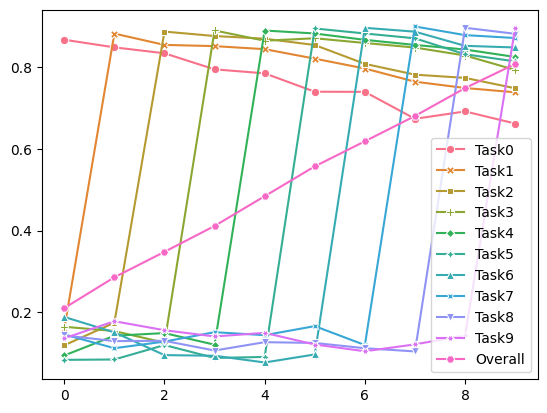

In [37]:
# lineplot every task acc per training
sns.lineplot(data=acc_df, dashes=False, markers=True)

# Qué clase se entrenó en cada tarea / experiencia?

# Store metrics

In [38]:
pickle.dump(acc_df, open(SAVED_METRICS_PATH / "ewc_kirkpatrick.pkl", "wb"))